In [1]:
#################### Plot Box and Whisker Plots of Percent of ###################################
############# Suspended Sediment that is Locally Suspended Over Time ############################
######################### With Sensitivity Test(s) ##############################################
# The purpose of this script is to make plots that have one box and whisker plot for 
# each shelf section that has the range of percentages of locally resuspended 
# sediment in that section over time. This is the same as plot_box_whiskers_river_sed_percent_time.py
# but edited to compared the standard runs to the sensitivity test(s) with different river
# discharge and sediment loads.
#
# Notes:
# - This leaves out the rivers that are no longer in the 2020 model
#   runs that use Blaskey river data 
# - This has been edited to read in the pre-processed data for standard runs and 
#   process the sensitivity test data 
# - The plots work better in xesmf_env
#########################################################################################

In [2]:
# Load in the packages 
import numpy as np
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import transforms 
from matplotlib import cm, ticker
from glob import glob
import cmocean
#import matplotlib.ticker as tick
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.patches as mpatches

In [3]:
# Set a universal fontsize
fontsize = 20 # 25

# Set the tick size for all plots
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize)

# Prevent tick labels from overlapping
matplotlib.rcParams['xtick.major.pad'] = 10 # 12
matplotlib.rcParams['ytick.major.pad'] = 10 # 12

In [4]:
# Load in the grid
grid = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Include/KakAKgrd_shelf_big010_smooth006.nc')
#grid = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Grids/KakAKgrd_shelf_big010_smooth006.nc') # UPDATE PATH


# Pull out some dimensions
eta_rho_len = len(grid.eta_rho)
xi_rho_len = len(grid.xi_rho)
s_rho_len = int(20)
Nbed_len = 11

In [5]:
# Multiply by masks to make land appear 
# Make it so land will appear
temp_mask = grid.mask_rho.copy()
temp_mask = np.where(temp_mask==0, np.nan, temp_mask)

In [6]:
# Load in the rho masks 
mask_rho_nan = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_ones_nans.nc') # UPDATE PATH
mask_rho_zeros = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_zeros_ones.nc')
#mask_rho_nan = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_ones_nans.nc')
#mask_rho_zeros = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_zeros_ones.nc')


#### Define a Bunch o Functions

In [7]:
# Make a function to get the depth-integrated kg sediment per cell in space
# as a time series
def get_depth_int_ssc_timeseries_by_class(filename, sediment_class):
    """
    This function takes a model output file, pulls out the desired 
    sediment class, gets the depth-integrated SSC as a time series.

    Parameters
    ----------
    filename : The name/path of the model output file
    sediment_class : The desired sediment class (str)

    Returns
    -------
    None.

    """
    
    # Load in the model output
    model_output = xr.open_dataset(filename)
    
    # Pull out the desired sediment class
    ssc_1sed = model_output[sediment_class]
    
    # To collapse to horizontal, multiply each layer by its
    # thickness
    # Calculate the time-varying thickness of the cells
    dz = abs(model_output.z_w[:,:-1,:,:].values - model_output.z_w[:,1:,:,:].values)
    
    # Multiply the SSC by thick thickness
    depth_int_ssc_1sed_tmp = (ssc_1sed*dz)
    
    # Then depth-integrated by summing over depth and dividing by dy
    depth_int_ssc_1sed = (depth_int_ssc_1sed_tmp.sum(dim='s_rho'))
    
    # Now we have SSC in kg/m2 for each grid cell in horizontal
    # Return this value - can multiply by dx and dy outside the function
    return(depth_int_ssc_1sed)

In [8]:
# Make a function that is the same as above but adds together 
# all riverine sediment to get bulk river values for standard runs 
# Make a function to get the depth-integrated kg sediment per cell in space
# as a time series
def get_depth_int_ssc_timeseries_bulk_river(filename):
    """
    This function takes a model output file, pulls out the desired 
    sediment class, gets the depth-integrated SSC as a time series.

    Parameters
    ----------
    filename : The name/path of the model output file

    Returns
    -------
    None.

    """
    
    # Load in the model output
    model_output = xr.open_dataset(filename)

    # Add together all the riverine sediment classes
    ssc_all_riv = (model_output.mud_15 + model_output.mud_16 + model_output.mud_17 + model_output.mud_18 +
                  model_output.mud_19 + model_output.mud_20 + model_output.mud_21 + model_output.mud_22 +
                  model_output.mud_23 + model_output.mud_24)
    
    # To collapse to horizontal, multiply each layer by its
    # thickness
    # Calculate the time-varying thickness of the cells
    dz = abs(model_output.z_w[:,:-1,:,:].values - model_output.z_w[:,1:,:,:].values)
    
    # Multiply the SSC by thick thickness
    depth_int_ssc_all_riv_tmp = (ssc_all_riv*dz)
    
    # Then depth-integrated by summing over depth and dividing by dy
    depth_int_ssc_all_riv = (depth_int_ssc_all_riv_tmp.sum(dim='s_rho'))
    
    # Now we have SSC in kg/m2 for each grid cell in horizontal
    # Return this value - can multiply by dx and dy outside the function
    return(depth_int_ssc_all_riv)

In [9]:
# Define a function to pull out the length of time in the model run
# And the time steps
def get_model_time(filenames, num_files):
    """
    This function loops though model output and pulls
    out the entire length of the run, as well as the 
    individual time steps of the run.
    
    Inputs:
    - filenames: path and name of model output
    - num_files: the number of model output files
    
    Outputs:
    - time_len: length of time of model run (integer)
    - time_steps_list: list of time steps of full run (datetimes64)
    - time_lengths: array holding the lenght of time of each output file
    """

    # Create an array to hold the length of time in each output file
    time_lengths = np.empty((num_files))

    # Loop through output to pull out lenth of time
    for k in range(num_files):
        # Open the output file
        model_output = xr.open_dataset(filenames[k])

        # Pull out the length of time 
        time_lengths[k] = len(model_output.ocean_time)

    # Now sum over all the lengths to get total time
    time_len = np.sum(time_lengths, axis=0)

    # Convert from float to int
    time_len = int(time_len)

    # Loop back through the output to pull out the time step and save it
    # Make a list to hold the time steps 
    time_steps_list = []
    # Loop through output
    for h in range(num_files):
        # Open the output file
        model_output = xr.open_dataset(filenames[h])

        # Get the length of the run
        output_len = len(model_output.ocean_time)

        # Loop through each time step and append it to the list
        for g in range(output_len):
            time_steps_list.append(model_output.ocean_time[g].values)

    # Return this time length and time steps
    return(time_len, time_steps_list, time_lengths)


In [10]:
# Multuply it by masks to get 0 - 10 m depth, 10  - 20 m depth, 20 - 30, 30 - 60
# Make masks for these depths 
# Make a function to mask the data but that takes two thresholds
def masked_array_lowhigh_2dloop(data, lower, upper):
    """
    This function takes an array and masks all values that are less
    than a certain given threshold. The functions returns 1 for areas that meet 
    the condition and 0 for areas that don't. So areas where the array is less
    than the threshold get returned as 1 and areas greater than the threshold
    are returned as 0. This function maintains the shape of the array.
    
    """
    mask_tmp = np.empty_like((data))
    
    # Loop through dimension 1
    for i in range(len(data[:,0])):
        # Loop through dimension 2
        for j in range(len(data[0,:])):
            # Compare against threshold 
            value = data[i,j]
            if lower < value <= upper:
                mask_tmp[i,j] = 1
            else:
                mask_tmp[i,j] = 0
    
    
    return (mask_tmp).astype(int)

In [11]:
# ---- Percent Over Time ----
# Calculate the percentage that is locally resuspended 
# Make a function to calculate the percentage over time 
def get_percent_regions_over_time_by_river(kg_sed_0_10m_riv, kg_sed_10_20m_riv, kg_sed_20_30m_riv, kg_sed_30_60m_riv):
    """
    This function takes given arrays of riverine suspended sediment (kg) in each depth
    region over time and calculates the percentage in each region over time. 

    Inputs:
    - kg_sed_0_10m_riv: Time series of the riverine suspended sediment (kg) from a given
                        river that is in 0 - 10 m depth
    - kg_sed_10_20m_riv: Time series of the riverine suspended sediment (kg) from a given
                        river that is in 10 - 20 m depth
    - kg_sed_20_30m_riv: Time series of the riverine suspended sediment (kg) from a given
                        river that is in 20 - 30 m depth
    - kg_sed_30_60m_riv: Time series of the riverine suspended sediment (kg) from a given
                        river that is in 30 - 60 m depth
    

    
    Outputs:
    - percent_0_10m: Time series of the percentage of riverine suspended sediment 
                      that is suspended in 0 - 10 m water depths over time, relative
                      to the total riverine suspended sediment from that river at that time
    - percent_10_20m: Time series of the percentage of riverine suspended sediment 
                      that is suspended in 10 - 20 m water depths over time, relative
                      to the total riverine suspended sediment from that river at that time
    - percent_20_30m: Time series of the percentage of riverine suspended sediment 
                      that is suspended in 20 - 30 m water depths over time, relative
                      to the total riverine suspended sediment from that river at that time
    - percent_30_60m: Time series of the percentage of riverine suspended sediment 
                      that is suspended in 30 - 60 m water depths over time, relative
                      to the total riverine suspended sediment from that river at that time
    """

    # Sum up all of the suspended sediment from this river in all depths over time
    tot_ssc_from_river = kg_sed_0_10m_riv + kg_sed_10_20m_riv + kg_sed_20_30m_riv + kg_sed_30_60m_riv

    # Calculate the percent that is in each depth range
    # 0 - 10 m
    percent_0_10m = (kg_sed_0_10m_riv/tot_ssc_from_river)*100
    # Check this 
    print('kg_sed_0_10m_riv[24]: ', kg_sed_0_10m_riv[24])
    print('tot_ssc_from_river[24]: ', tot_ssc_from_river[24])
    print('percent_0_10m[24]: ', percent_0_10m[24])
    # 10 - 20 m
    percent_10_20m = (kg_sed_10_20m_riv/tot_ssc_from_river)*100
    # 20 - 30 m
    percent_20_30m = (kg_sed_20_30m_riv/tot_ssc_from_river)*100
    # 30 - 60 m
    percent_30_60m = (kg_sed_30_60m_riv/tot_ssc_from_river)*100

    # Return this value...
    return(percent_0_10m, percent_10_20m, percent_20_30m, percent_30_60m)


#### Process the Sensitivty Test Output

In [12]:
# Load in the model output
# Double discharge sensitivity test
file_names = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_*.nc')

In [13]:
# Sort them to be in order
file_names2 = sorted(file_names)

# Check to see if this worked
print(file_names2[0], flush=True)
print(file_names2[1], flush=True)
print(file_names2[2], flush=True)
print(file_names2[-1], flush=True)
print('all files: ', file_names2, flush=True)

# Pull out the number of files
num_files = len(file_names2)

/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_00001.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_00002.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_00003.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_00018.nc
all files:  ['/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_00001.nc', '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_00002.nc', '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_00003.nc', '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_00004.nc', '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_double_00005.nc', '/scratch/alpine/brun1463/R

In [14]:
# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
full_time_len, time_steps, time_lengths = get_model_time(file_names2, num_files)

In [15]:
# Make some arrays to hold output
# One for each sediment type in the river muds - look at guide
# Unagggregated
depth_int_ssc_mud03 = np.empty((full_time_len, eta_rho_len, xi_rho_len))
# Aggregated 
depth_int_ssc_mud04 = np.empty((full_time_len, eta_rho_len, xi_rho_len))


In [16]:
# Set a time step to track which time step the loop is on
time_step = 0

# Loop through the model output
for j in range(num_files):
#for j in range(1):

    print('j: ', j, flush=True)
    
    # Call the function to process the output and Save these to the arrays 
    #print('time_step: ', time_step)
    #print('time_step + time_lengths[j]: ', time_step+time_lengths[j])
    start = int(time_step)
    end = int(time_step+time_lengths[j])
    
    # Mud03
    depth_int_ssc_mud03[start:end,:,:] = get_depth_int_ssc_timeseries_by_class(file_names2[j], 'mud_03')
    # Mud04
    depth_int_ssc_mud04[start:end,:,:] = get_depth_int_ssc_timeseries_by_class(file_names2[j], 'mud_04')

    # Update the base time_step
    time_step = time_step + time_lengths[j]

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17


In [17]:
# Okay now multiply by dx and dy, and rename to be by river and combine where needed
dx = 750 # meters
dy = 600 # meters 

# Unaggregated
kg_sed_riv_unag = depth_int_ssc_mud03*dx*dy # kg
# Aggregated
kg_sed_riv_agg = depth_int_ssc_mud04*dx*dy # kg

# Check the shapes 
print(np.shape(kg_sed_riv_unag))

(751, 206, 608)


In [18]:
# Multiply by mask to get region we trust 
# Set the number of cells in the sponge on each open boundary
c_west = 36
c_north = 45
c_east = 36
# Make it so land will appear
temp_mask = grid.mask_rho.copy()
temp_mask = np.where(temp_mask==0, np.nan, temp_mask)
# Mask, trim
# Make empty arrays to hold masked and trimmed versions 
kg_sed_riv_unag_masked = np.empty((full_time_len,eta_rho_len,xi_rho_len))
kg_sed_riv_agg_masked = np.empty((full_time_len,eta_rho_len,xi_rho_len))

# Loop through time
for t in range(full_time_len):
    print('t: ', t, flush=True)
    
    # Mask
    kg_sed_riv_unag_masked[t,:,:] = kg_sed_riv_unag[t,:,:]*temp_mask*mask_rho_nan.nudge_mask_rho_nan
    kg_sed_riv_agg_masked[t,:,:] = kg_sed_riv_agg[t,:,:]*temp_mask*mask_rho_nan.nudge_mask_rho_nan
    


t:  0
t:  1
t:  2
t:  3
t:  4
t:  5
t:  6
t:  7
t:  8
t:  9
t:  10
t:  11
t:  12
t:  13
t:  14
t:  15
t:  16
t:  17
t:  18
t:  19
t:  20
t:  21
t:  22
t:  23
t:  24
t:  25
t:  26
t:  27
t:  28
t:  29
t:  30
t:  31
t:  32
t:  33
t:  34
t:  35
t:  36
t:  37
t:  38
t:  39
t:  40
t:  41
t:  42
t:  43
t:  44
t:  45
t:  46
t:  47
t:  48
t:  49
t:  50
t:  51
t:  52
t:  53
t:  54
t:  55
t:  56
t:  57
t:  58
t:  59
t:  60
t:  61
t:  62
t:  63
t:  64
t:  65
t:  66
t:  67
t:  68
t:  69
t:  70
t:  71
t:  72
t:  73
t:  74
t:  75
t:  76
t:  77
t:  78
t:  79
t:  80
t:  81
t:  82
t:  83
t:  84
t:  85
t:  86
t:  87
t:  88
t:  89
t:  90
t:  91
t:  92
t:  93
t:  94
t:  95
t:  96
t:  97
t:  98
t:  99
t:  100
t:  101
t:  102
t:  103
t:  104
t:  105
t:  106
t:  107
t:  108
t:  109
t:  110
t:  111
t:  112
t:  113
t:  114
t:  115
t:  116
t:  117
t:  118
t:  119
t:  120
t:  121
t:  122
t:  123
t:  124
t:  125
t:  126
t:  127
t:  128
t:  129
t:  130
t:  131
t:  132
t:  133
t:  134
t:  135
t:  136
t:  137
t:  13

In [19]:
# Call the function to make the mask
# First make an array of the bathymetry of the grid pre-masked
h_masked = grid.h * mask_rho_nan.nudge_mask_rho_nan
# 0 - 10 m
h_masked1 = h_masked.copy()
inner_10m_mask_rho = masked_array_lowhigh_2dloop(h_masked1, 2, 10)
# 10 - 20 m
h_masked2 = h_masked.copy()
outer_10_20m_mask_rho = masked_array_lowhigh_2dloop(h_masked2, 10, 20)
# 20 - 30 m 
h_masked3 = h_masked.copy()
outer_20_30m_mask_rho = masked_array_lowhigh_2dloop(h_masked3, 20, 30)
# 30 - 60 m depth
h_masked4 = h_masked.copy()
outer_30_60m_mask_rho = masked_array_lowhigh_2dloop(h_masked4, 30, 60)

# Make the masks nan where they are 0 so that these out of bounds areas are 
# nanned out 
# 0 - 10 m
inner_10m_mask_rho_nan_idx = np.where(inner_10m_mask_rho == 0.0)
inner_10m_mask_rho_nan = inner_10m_mask_rho .copy()
inner_10m_mask_rho_nan = inner_10m_mask_rho_nan.astype('float')
inner_10m_mask_rho_nan[inner_10m_mask_rho_nan_idx] = np.nan
# 10 - 20 m
outer_10_20m_mask_rho_nan_idx = np.where(outer_10_20m_mask_rho == 0.0)
outer_10_20m_mask_rho_nan = outer_10_20m_mask_rho.copy()
outer_10_20m_mask_rho_nan = outer_10_20m_mask_rho_nan.astype('float')
outer_10_20m_mask_rho_nan[outer_10_20m_mask_rho_nan_idx] = np.nan
# 20 - 30 m
outer_20_30m_mask_rho_nan_idx = np.where(outer_20_30m_mask_rho == 0.0)
outer_20_30m_mask_rho_nan = outer_20_30m_mask_rho.copy()
outer_20_30m_mask_rho_nan = outer_20_30m_mask_rho_nan.astype('float')
outer_20_30m_mask_rho_nan[outer_20_30m_mask_rho_nan_idx] = np.nan
# 30 - 60 m depth
outer_30_60m_mask_rho_nan_idx = np.where(outer_30_60m_mask_rho == 0.0)
outer_30_60m_mask_rho_nan = outer_30_60m_mask_rho.copy()
outer_30_60m_mask_rho_nan = outer_30_60m_mask_rho_nan.astype('float')
outer_30_60m_mask_rho_nan[outer_30_60m_mask_rho_nan_idx] = np.nan

In [20]:
# Now multiply by the mask to get the different regions 
# Make empty arrays to hold the values
# Unaggregated
kg_sed_0_10m_unag_double = np.empty((full_time_len,eta_rho_len,xi_rho_len))
kg_sed_10_20m_unag_double = np.empty((full_time_len,eta_rho_len,xi_rho_len))
kg_sed_20_30m_unag_double = np.empty((full_time_len,eta_rho_len,xi_rho_len))
kg_sed_30_60m_unag_double = np.empty((full_time_len,eta_rho_len,xi_rho_len))
# Aggregated
kg_sed_0_10m_agg_double = np.empty((full_time_len,eta_rho_len,xi_rho_len))
kg_sed_10_20m_agg_double = np.empty((full_time_len,eta_rho_len,xi_rho_len))
kg_sed_20_30m_agg_double = np.empty((full_time_len,eta_rho_len,xi_rho_len))
kg_sed_30_60m_agg_double = np.empty((full_time_len,eta_rho_len,xi_rho_len))

# Loop through time 
for tt in range(full_time_len):
    print('tt: ', tt, flush=True)
        
    # Unaggregated
    kg_sed_0_10m_unag_double[tt,:,:] = kg_sed_riv_unag_masked[tt,:,:]*inner_10m_mask_rho_nan
    kg_sed_10_20m_unag_double[tt,:,:] = kg_sed_riv_unag_masked[tt,:,:]*outer_10_20m_mask_rho_nan
    kg_sed_20_30m_unag_double[tt,:,:] = kg_sed_riv_unag_masked[tt,:,:]*outer_20_30m_mask_rho_nan
    kg_sed_30_60m_unag_double[tt,:,:] = kg_sed_riv_unag_masked[tt,:,:]*outer_30_60m_mask_rho_nan
    # Aggregated
    kg_sed_0_10m_agg_double[tt,:,:] = kg_sed_riv_agg_masked[tt,:,:]*inner_10m_mask_rho_nan
    kg_sed_10_20m_agg_double[tt,:,:] = kg_sed_riv_agg_masked[tt,:,:]*outer_10_20m_mask_rho_nan
    kg_sed_20_30m_agg_double[tt,:,:] = kg_sed_riv_agg_masked[tt,:,:]*outer_20_30m_mask_rho_nan
    kg_sed_30_60m_agg_double[tt,:,:] = kg_sed_riv_agg_masked[tt,:,:]*outer_30_60m_mask_rho_nan


tt:  0
tt:  1
tt:  2
tt:  3
tt:  4
tt:  5
tt:  6
tt:  7
tt:  8
tt:  9
tt:  10
tt:  11
tt:  12
tt:  13
tt:  14
tt:  15
tt:  16
tt:  17
tt:  18
tt:  19
tt:  20
tt:  21
tt:  22
tt:  23
tt:  24
tt:  25
tt:  26
tt:  27
tt:  28
tt:  29
tt:  30
tt:  31
tt:  32
tt:  33
tt:  34
tt:  35
tt:  36
tt:  37
tt:  38
tt:  39
tt:  40
tt:  41
tt:  42
tt:  43
tt:  44
tt:  45
tt:  46
tt:  47
tt:  48
tt:  49
tt:  50
tt:  51
tt:  52
tt:  53
tt:  54
tt:  55
tt:  56
tt:  57
tt:  58
tt:  59
tt:  60
tt:  61
tt:  62
tt:  63
tt:  64
tt:  65
tt:  66
tt:  67
tt:  68
tt:  69
tt:  70
tt:  71
tt:  72
tt:  73
tt:  74
tt:  75
tt:  76
tt:  77
tt:  78
tt:  79
tt:  80
tt:  81
tt:  82
tt:  83
tt:  84
tt:  85
tt:  86
tt:  87
tt:  88
tt:  89
tt:  90
tt:  91
tt:  92
tt:  93
tt:  94
tt:  95
tt:  96
tt:  97
tt:  98
tt:  99
tt:  100
tt:  101
tt:  102
tt:  103
tt:  104
tt:  105
tt:  106
tt:  107
tt:  108
tt:  109
tt:  110
tt:  111
tt:  112
tt:  113
tt:  114
tt:  115
tt:  116
tt:  117
tt:  118
tt:  119
tt:  120
tt:  121
tt:  122
tt:

In [21]:
# Trim
# Unaggregated
kg_sed_0_10m_unag_double_masked_trimmed = kg_sed_0_10m_unag_double[:,:,c_west:-c_west]
kg_sed_10_20m_unag_double_masked_trimmed = kg_sed_10_20m_unag_double[:,:,c_west:-c_west]
kg_sed_20_30m_unag_double_masked_trimmed = kg_sed_20_30m_unag_double[:,:,c_west:-c_west]
kg_sed_30_60m_unag_double_masked_trimmed = kg_sed_30_60m_unag_double[:,:,c_west:-c_west]
# Aggregated
kg_sed_0_10m_agg_double_masked_trimmed = kg_sed_0_10m_agg_double[:,:,c_west:-c_west]
kg_sed_10_20m_agg_double_masked_trimmed = kg_sed_10_20m_agg_double[:,:,c_west:-c_west]
kg_sed_20_30m_agg_double_masked_trimmed = kg_sed_20_30m_agg_double[:,:,c_west:-c_west]
kg_sed_30_60m_agg_double_masked_trimmed = kg_sed_30_60m_agg_double[:,:,c_west:-c_west]

In [22]:
# Then assuming it worked, sum over each region to get a kg per time for each
# class in each region
# Unaggregated 
kg_sed_0_10m_unag_double_masked_trimmed_sum = np.nansum(kg_sed_0_10m_unag_double_masked_trimmed, axis=(1,2))
kg_sed_10_20m_unag_double_masked_trimmed_sum = np.nansum(kg_sed_10_20m_unag_double_masked_trimmed, axis=(1,2))
kg_sed_20_30m_unag_double_masked_trimmed_sum = np.nansum(kg_sed_20_30m_unag_double_masked_trimmed, axis=(1,2))
kg_sed_30_60m_unag_double_masked_trimmed_sum = np.nansum(kg_sed_30_60m_unag_double_masked_trimmed, axis=(1,2))
# Aggregated 
kg_sed_0_10m_agg_double_masked_trimmed_sum = np.nansum(kg_sed_0_10m_agg_double_masked_trimmed, axis=(1,2))
kg_sed_10_20m_agg_double_masked_trimmed_sum = np.nansum(kg_sed_10_20m_agg_double_masked_trimmed, axis=(1,2))
kg_sed_20_30m_agg_double_masked_trimmed_sum = np.nansum(kg_sed_20_30m_agg_double_masked_trimmed, axis=(1,2))
kg_sed_30_60m_agg_double_masked_trimmed_sum = np.nansum(kg_sed_30_60m_agg_double_masked_trimmed, axis=(1,2))


In [23]:
# ---------------- Trim to Time we Trust --------------------
# *** Not applicable to sensitivity tests yet --> applicable now! 
# Trim all of these variables to the time that we trust 
# Unaggregated
kg_sed_0_10m_unag_double_masked_trimmed_sum = kg_sed_0_10m_unag_double_masked_trimmed_sum[:738]
kg_sed_10_20m_unag_double_masked_trimmed_sum = kg_sed_10_20m_unag_double_masked_trimmed_sum[:738]
kg_sed_20_30m_unag_double_masked_trimmed_sum = kg_sed_20_30m_unag_double_masked_trimmed_sum[:738]
kg_sed_30_60m_unag_double_masked_trimmed_sum = kg_sed_30_60m_unag_double_masked_trimmed_sum[:738]
# Aggregated
kg_sed_0_10m_agg_double_masked_trimmed_sum = kg_sed_0_10m_agg_double_masked_trimmed_sum[:738]
kg_sed_10_20m_agg_double_masked_trimmed_sum = kg_sed_10_20m_agg_double_masked_trimmed_sum[:738]
kg_sed_20_30m_agg_double_masked_trimmed_sum = kg_sed_20_30m_agg_double_masked_trimmed_sum[:738]
kg_sed_30_60m_agg_double_masked_trimmed_sum = kg_sed_30_60m_agg_double_masked_trimmed_sum[:738]
# Combined aggregated and unaggregated
# Aggregated
kg_sed_0_10m_all_double_masked_trimmed_sum = kg_sed_0_10m_agg_double_masked_trimmed_sum + kg_sed_0_10m_unag_double_masked_trimmed_sum
kg_sed_10_20m_all_double_masked_trimmed_sum = kg_sed_10_20m_agg_double_masked_trimmed_sum + kg_sed_10_20m_unag_double_masked_trimmed_sum
kg_sed_20_30m_all_double_masked_trimmed_sum = kg_sed_20_30m_agg_double_masked_trimmed_sum + kg_sed_20_30m_unag_double_masked_trimmed_sum
kg_sed_30_60m_all_double_masked_trimmed_sum = kg_sed_30_60m_agg_double_masked_trimmed_sum + kg_sed_30_60m_unag_double_masked_trimmed_sum

In [24]:
# Call the function for each river 
# Unaggregated
percent_0_10m_unag_double, percent_10_20m_unag_double, percent_20_30m_unag_double, percent_30_60m_unag_double = get_percent_regions_over_time_by_river(kg_sed_0_10m_unag_double_masked_trimmed_sum, kg_sed_10_20m_unag_double_masked_trimmed_sum, kg_sed_20_30m_unag_double_masked_trimmed_sum, kg_sed_30_60m_unag_double_masked_trimmed_sum)
# Aggregated
percent_0_10m_agg_double, percent_10_20m_agg_double, percent_20_30m_agg_double, percent_30_60m_agg_double = get_percent_regions_over_time_by_river(kg_sed_0_10m_agg_double_masked_trimmed_sum, kg_sed_10_20m_agg_double_masked_trimmed_sum, kg_sed_20_30m_agg_double_masked_trimmed_sum, kg_sed_30_60m_agg_double_masked_trimmed_sum)
# Combined aggregated and unaggregated 
percent_0_10m_all_double, percent_10_20m_all_double, percent_20_30m_all_double, percent_30_60m_all_double = get_percent_regions_over_time_by_river(kg_sed_0_10m_all_double_masked_trimmed_sum, kg_sed_10_20m_all_double_masked_trimmed_sum, kg_sed_20_30m_all_double_masked_trimmed_sum, kg_sed_30_60m_all_double_masked_trimmed_sum)


kg_sed_0_10m_riv[24]:  17701311.9425323
tot_ssc_from_river[24]:  17994058.72412108
percent_0_10m[24]:  98.37309199621345
kg_sed_0_10m_riv[24]:  1117612.6394095537
tot_ssc_from_river[24]:  1117612.6582088852
percent_0_10m[24]:  99.99999831790277
kg_sed_0_10m_riv[24]:  18818924.581941854
tot_ssc_from_river[24]:  19111671.382329963
percent_0_10m[24]:  98.46823025296064


/projects/brun1463/software/anaconda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/projects/brun1463/software/anaconda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/projects/brun1463/software/anaconda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide
/projects/brun1463/software/anaconda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide


In [25]:
# Save to a netcdf
# Save these to a netcdf since the analysis takes so long?
percent_regions_over_time_byriver = xr.Dataset(
    data_vars=dict(
        percent_0_10m_unag_double=(['ocean_time'], percent_0_10m_unag_double),
        percent_10_20m_unag_double=(['ocean_time'], percent_10_20m_unag_double),
        percent_20_30m_unag_double=(['ocean_time'], percent_20_30m_unag_double),
        percent_30_60m_unag_double=(['ocean_time'], percent_30_60m_unag_double),
        percent_0_10m_agg_double=(['ocean_time'], percent_0_10m_agg_double),
        percent_10_20m_agg_double=(['ocean_time'], percent_10_20m_agg_double),
        percent_20_30m_agg_double=(['ocean_time'], percent_20_30m_agg_double),
        percent_30_60m_agg_double=(['ocean_time'], percent_30_60m_agg_double),
        percent_0_10m_all_double=(['ocean_time'], percent_0_10m_all_double),
        percent_10_20m_all_double=(['ocean_time'], percent_10_20m_all_double),
        percent_20_30m_all_double=(['ocean_time'], percent_20_30m_all_double),
        percent_30_60m_all_double=(['ocean_time'], percent_30_60m_all_double),
    ),
    coords=dict(
        ocean_time=('ocean_time', time_steps[:738])
    ),
    attrs=dict(description='Time-series ROMS output of percent of riverine suspended sediment in each region by sediment class for double discharge sensitivity test')
)

# Save to a netcdf
# Sensitivity test
#percent_regions_over_time_byriver.to_netcdf('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/Percent_river_suspended_sed_regions/percent_river_suspended_sed_over_time_in_regions_double_dis_full_02.nc')


#### Process the Standard Runs in a Bulk Way 

In [ ]:
# Load in the standard run output
# -- Aggregated --
# 2020 dbsed0001 - full run 
#file_names = glob('/pl/active/moriarty_lab/BriannaU/Paper2/Model_Output/Aggregated/dbsed0001_10rivs/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_*.nc')
file_names_agg = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_*.nc')
# -- Unaggregated --
# 2020 dbsed0001 - full run
#file_names = glob('/pl/active/moriarty_lab/BriannaU/Paper2/Model_Output/Unaggregated/dbsed0001_10rivs_unaggregated/ocean_his_beaufort_rivers_10rivs_13seabed_unaggregated_dbsed0001_*.nc') 
file_names_unag = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_003_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_unaggregated_dbsed0001_*.nc')

In [ ]:
# Sort them to be in order
# Aggregated 
file_names2_agg = sorted(file_names_agg)

# Check to see if this worked
print(file_names2_agg[0], flush=True)
print(file_names2_agg[1], flush=True)
print(file_names2_agg[2], flush=True)
print(file_names2_agg[-1], flush=True)
print('all files: ', file_names2_agg, flush=True)

# Pull out the number of files
num_files_agg = len(file_names2_agg)

# Unaggregated
file_names2_unag = sorted(file_names_unag)

# Check to see if this worked
print(file_names2_unag[0], flush=True)
print(file_names2_unag[1], flush=True)
print(file_names2_unag[2], flush=True)
print(file_names2_unag[-1], flush=True)
print('all files: ', file_names2_unag, flush=True)

# Pull out the number of files
num_files_unag = len(file_names2_unag)

In [ ]:
print(file_names2_agg)
print(file_names2_unag)

In [ ]:
# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
full_time_len_agg, time_steps_agg, time_lengths_agg = get_model_time(file_names2_agg, num_files_agg)
full_time_len_unag, time_steps_unag, time_lengths_unag = get_model_time(file_names2_unag, num_files_unag)

In [ ]:
# Make some arrays to hold output
# One for each sediment type in the river muds - look at guide
# Unagggregated
depth_int_ssc_unag_std = np.empty((full_time_len_unag, eta_rho_len, xi_rho_len))
# Aggregated 
depth_int_ssc_agg_std = np.empty((full_time_len_agg, eta_rho_len, xi_rho_len))

In [ ]:
print(full_time_len_agg)
print(full_time_len_unag)

In [ ]:
print(num_files_agg)
print(num_files_unag)

In [ ]:
# Set a time step to track which time step the loop is on
time_step_agg = 0
time_step_unag = 0

# Loop through the model output
for j in range(num_files_agg):
#for j in range(1):

    print('j: ', j, flush=True)
    
    # Call the function to process the output and Save these to the arrays 
    #print('time_step: ', time_step)
    #print('time_step + time_lengths[j]: ', time_step+time_lengths[j])
    start_agg = int(time_step_agg)
    end_agg = int(time_step_agg+time_lengths_agg[j])
    start_unag = int(time_step_unag)
    end_unag = int(time_step_agg+time_lengths_unag[j])
    
    # Unaggregated
    depth_int_ssc_unag_std[start_unag:end_unag,:,:] = get_depth_int_ssc_timeseries_bulk_river(file_names2_unag[j])
    # Aggregated
    depth_int_ssc_agg_std[start_agg:end_agg,:,:] = get_depth_int_ssc_timeseries_bulk_river(file_names2_agg[j])

    # Update the base time_step
    time_step_agg = time_step_agg + time_lengths_agg[j]
    time_step_unag = time_step_unag + time_lengths_unag[j]

In [ ]:
# Okay now multiply by dx and dy, and rename to be by river and combine where needed
dx = 750 # meters
dy = 600 # meters 

# Unaggregated
kg_sed_riv_unag_std = depth_int_ssc_unag_std*dx*dy # kg
# Aggregated
kg_sed_riv_agg_std = depth_int_ssc_agg_std*dx*dy # kg

# Check the shapes 
print(np.shape(kg_sed_riv_unag_std))

In [ ]:
# Multiply by mask to get region we trust 
# Set the number of cells in the sponge on each open boundary
c_west = 36
c_north = 45
c_east = 36
# Make it so land will appear
temp_mask = grid.mask_rho.copy()
temp_mask = np.where(temp_mask==0, np.nan, temp_mask)
# Mask, trim
# Make empty arrays to hold masked and trimmed versions 
kg_sed_riv_unag_std_masked = np.empty((full_time_len_unag,eta_rho_len,xi_rho_len))
kg_sed_riv_agg_std_masked = np.empty((full_time_len_agg,eta_rho_len,xi_rho_len))

# Loop through time
# Aggregated
for t in range(full_time_len_agg):
    print('t: ', t, flush=True) 
    # Mask
    kg_sed_riv_agg_std_masked[t,:,:] = kg_sed_riv_agg_std[t,:,:]*temp_mask*mask_rho_nan.nudge_mask_rho_nan
# Unaggregated
for tt in range(full_time_len_unag):
    print('tt: ', tt, flush=True)
    
    # Mask
    kg_sed_riv_unag_std_masked[tt,:,:] = kg_sed_riv_unag_std[tt,:,:]*temp_mask*mask_rho_nan.nudge_mask_rho_nan

In [ ]:
# Now multiply by the mask to get the different regions 
# Make empty arrays to hold the values
# Unaggregated
kg_sed_0_10m_unag_std = np.empty((full_time_len_unag,eta_rho_len,xi_rho_len))
kg_sed_10_20m_unag_std = np.empty((full_time_len_unag,eta_rho_len,xi_rho_len))
kg_sed_20_30m_unag_std = np.empty((full_time_len_unag,eta_rho_len,xi_rho_len))
kg_sed_30_60m_unag_std = np.empty((full_time_len_unag,eta_rho_len,xi_rho_len))
# Aggregated
kg_sed_0_10m_agg_std = np.empty((full_time_len_agg,eta_rho_len,xi_rho_len))
kg_sed_10_20m_agg_std = np.empty((full_time_len_agg,eta_rho_len,xi_rho_len))
kg_sed_20_30m_agg_std = np.empty((full_time_len_agg,eta_rho_len,xi_rho_len))
kg_sed_30_60m_agg_std = np.empty((full_time_len_agg,eta_rho_len,xi_rho_len))

# Loop through time 
# Aggregated
for tt in range(full_time_len_agg):
    print('tt: ', tt, flush=True)
    # Aggregated
    kg_sed_0_10m_agg_std[tt,:,:] = kg_sed_riv_agg_std_masked[tt,:,:]*inner_10m_mask_rho_nan
    kg_sed_10_20m_agg_std[tt,:,:] = kg_sed_riv_agg_std_masked[tt,:,:]*outer_10_20m_mask_rho_nan
    kg_sed_20_30m_agg_std[tt,:,:] = kg_sed_riv_agg_std_masked[tt,:,:]*outer_20_30m_mask_rho_nan
    kg_sed_30_60m_agg_std[tt,:,:] = kg_sed_riv_agg_std_masked[tt,:,:]*outer_30_60m_mask_rho_nan
# Unaggregated
for tt in range(full_time_len_unag):
    print('tt: ', tt, flush=True)
        
    # Unaggregated
    kg_sed_0_10m_unag_std[tt,:,:] = kg_sed_riv_unag_std_masked[tt,:,:]*inner_10m_mask_rho_nan
    kg_sed_10_20m_unag_std[tt,:,:] = kg_sed_riv_unag_std_masked[tt,:,:]*outer_10_20m_mask_rho_nan
    kg_sed_20_30m_unag_std[tt,:,:] = kg_sed_riv_unag_std_masked[tt,:,:]*outer_20_30m_mask_rho_nan
    kg_sed_30_60m_unag_std[tt,:,:] = kg_sed_riv_unag_std_masked[tt,:,:]*outer_30_60m_mask_rho_nan


In [ ]:
# Trim
# Unaggregated
kg_sed_0_10m_unag_std_masked_trimmed = kg_sed_0_10m_unag_std[:,:,c_west:-c_west]
kg_sed_10_20m_unag_std_masked_trimmed = kg_sed_10_20m_unag_std[:,:,c_west:-c_west]
kg_sed_20_30m_unag_std_masked_trimmed = kg_sed_20_30m_unag_std[:,:,c_west:-c_west]
kg_sed_30_60m_unag_std_masked_trimmed = kg_sed_30_60m_unag_std[:,:,c_west:-c_west]
# Aggregated
kg_sed_0_10m_agg_std_masked_trimmed = kg_sed_0_10m_agg_std[:,:,c_west:-c_west]
kg_sed_10_20m_agg_std_masked_trimmed = kg_sed_10_20m_agg_std[:,:,c_west:-c_west]
kg_sed_20_30m_agg_std_masked_trimmed = kg_sed_20_30m_agg_std[:,:,c_west:-c_west]
kg_sed_30_60m_agg_std_masked_trimmed = kg_sed_30_60m_agg_std[:,:,c_west:-c_west]

In [ ]:
# Then assuming it worked, sum over each region to get a kg per time for each
# class in each region
# Unaggregated 
kg_sed_0_10m_unag_std_masked_trimmed_sum = np.nansum(kg_sed_0_10m_unag_std_masked_trimmed, axis=(1,2))
kg_sed_10_20m_unag_std_masked_trimmed_sum = np.nansum(kg_sed_10_20m_unag_std_masked_trimmed, axis=(1,2))
kg_sed_20_30m_unag_std_masked_trimmed_sum = np.nansum(kg_sed_20_30m_unag_std_masked_trimmed, axis=(1,2))
kg_sed_30_60m_unag_std_masked_trimmed_sum = np.nansum(kg_sed_30_60m_unag_std_masked_trimmed, axis=(1,2))
# Aggregated 
kg_sed_0_10m_agg_std_masked_trimmed_sum = np.nansum(kg_sed_0_10m_agg_std_masked_trimmed, axis=(1,2))
kg_sed_10_20m_agg_std_masked_trimmed_sum = np.nansum(kg_sed_10_20m_agg_std_masked_trimmed, axis=(1,2))
kg_sed_20_30m_agg_std_masked_trimmed_sum = np.nansum(kg_sed_20_30m_agg_std_masked_trimmed, axis=(1,2))
kg_sed_30_60m_agg_std_masked_trimmed_sum = np.nansum(kg_sed_30_60m_agg_std_masked_trimmed, axis=(1,2))

In [ ]:
# Call the function for each river 
# Unaggregated
percent_0_10m_unag_std, percent_10_20m_unag_std, percent_20_30m_unag_std, percent_30_60m_unag_std = get_percent_regions_over_time_by_river(kg_sed_0_10m_unag_std_masked_trimmed_sum, kg_sed_10_20m_unag_std_masked_trimmed_sum, kg_sed_20_30m_unag_std_masked_trimmed_sum, kg_sed_30_60m_unag_std_masked_trimmed_sum)
# Aggregated
percent_0_10m_agg_std, percent_10_20m_agg_std, percent_20_30m_agg_std, percent_30_60m_agg_std = get_percent_regions_over_time_by_river(kg_sed_0_10m_agg_std_masked_trimmed_sum, kg_sed_10_20m_agg_std_masked_trimmed_sum, kg_sed_20_30m_agg_std_masked_trimmed_sum, kg_sed_30_60m_agg_std_masked_trimmed_sum)


In [ ]:
# Before plotting and moving on, trim them all to just the time of the 
# model run that we trust (end on October 30)
print('Time step (0): ', time_steps[0], flush=True)
print('Time step (-1): ', time_steps[-1], flush=True)

# First find that time
# print('full_time_len: ', full_time_len, flush=True)
# print('Time step (720): ', time_steps[720], flush=True)
# print('Time step (721): ', time_steps[721], flush=True)
# print('Time step (722): ', time_steps[722], flush=True)
# print('Time step (730): ', time_steps[730], flush=True)
# print('Time step (736): ', time_steps[736], flush=True)
# print('Time step (737): ', time_steps[737], flush=True)
# print('Time step (738): ', time_steps[738], flush=True)
# print('Time step (740): ', time_steps[740], flush=True)

# ---------------- Trim to Time we Trust --------------------
# Trim all of these variables to the time that we trust 
# Unaggregated 
percent_0_10m_unag_std = percent_0_10m_unag_std[:738]
percent_10_20m_unag_std = percent_10_20m_unag_std[:738]
percent2_0310m_unag_std = percent_20_30m_unag_std[:738]
percen3t_6_10m_unag_std = percent_30_60m_unag_std[:738]
# Aggregated
percent_0_10m_agg_std = percent_0_10m_agg_std[:738]
percent_10_20m_agg_std = percent_10_20m_agg_std[:738]
percent2_0310m_agg_std = percent_20_30m_agg_std[:738]
percen3t_6_10m_agg_std = percent_30_60m_agg_std[:738]

In [ ]:
# Save to a netcdf
# Save these to a netcdf since the analysis takes so long?
percent_regions_over_time_bulk_std = xr.Dataset(
    data_vars=dict(
        percent_0_10m_unag_std=(['ocean_time'], percent_0_10m_unag_std),
        percent_10_20m_unag_std=(['ocean_time'], percent_10_20m_unag_std),
        percent_20_30m_unag_std=(['ocean_time'], percent_20_30m_unag_std),
        percent_30_60m_unag_std=(['ocean_time'], percent_30_60m_unag_std),
        percent_0_10m_agg_std=(['ocean_time'], percent_0_10m_agg_std),
        percent_10_20m_agg_std=(['ocean_time'], percent_10_20m_agg_std),
        percent_20_30m_agg_std=(['ocean_time'], percent_20_30m_agg_std),
        percent_30_60m_agg_std=(['ocean_time'], percent_30_60m_agg_std),
    ),
    coords=dict(
        ocean_time=('ocean_time', time_steps_agg[:738])
    ),
    attrs=dict(description='Time-series ROMS output of percent of riverine suspended sediment in each region by sediment class for the standard runs')
)

# Save to a netcdf
# Standard
#percent_regions_over_time_bulk_std.to_netcdf('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/Percent_river_suspended_sed_regions/percent_river_suspended_sed_over_time_in_regions_bulk_std.nc')


#### Plot!
Pick up here if the post-processing of the standard runs works (don't do the post-processing of the standard runs here unless absolutely needed since it will take ~300 minutes which is about 5 hours and will probably time out)

In [26]:
# Load in the post-processed output for bulk standard run 
# Standard run 
riv_sed_percent_std = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/Percent_river_suspended_sed_regions/percent_river_suspended_sed_over_time_in_regions_bulk_std_03.nc')

In [27]:
# Load in post-processed output for sensitivity tests
riv_sed_percent_double = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/Percent_river_suspended_sed_regions/percent_river_suspended_sed_over_time_in_regions_double_dis_full_02.nc')

In [38]:
# Cimbine these for plotting 
# If I need to trim it in time to get it to match, do it here
river_sed_percent_0_10m = (riv_sed_percent_std.percent_0_10m_agg_std, riv_sed_percent_std.percent_0_10m_unag_std, riv_sed_percent_double.percent_0_10m_agg_double, riv_sed_percent_double.percent_0_10m_unag_double)
river_sed_percent_10_20m = (riv_sed_percent_std.percent_10_20m_agg_std, riv_sed_percent_std.percent_10_20m_unag_std, riv_sed_percent_double.percent_10_20m_agg_double, riv_sed_percent_double.percent_10_20m_unag_double)
river_sed_percent_20_30m = (riv_sed_percent_std.percent_20_30m_agg_std, riv_sed_percent_std.percent_20_30m_unag_std, riv_sed_percent_double.percent_20_30m_agg_double, riv_sed_percent_double.percent_20_30m_unag_double)
river_sed_percent_30_60m = (riv_sed_percent_std.percent_30_60m_agg_std, riv_sed_percent_std.percent_30_60m_unag_std, riv_sed_percent_double.percent_30_60m_agg_double, riv_sed_percent_double.percent_30_60m_unag_double)

# Do all sed combined
river_allsed_percent_0_10m = (riv_sed_percent_std.percent_0_10m_all_std, riv_sed_percent_double.percent_0_10m_all_double,)
river_allsed_percent_10_20m = (riv_sed_percent_std.percent_10_20m_all_std, riv_sed_percent_double.percent_10_20m_all_double)
river_allsed_percent_20_30m = (riv_sed_percent_std.percent_20_30m_all_std, riv_sed_percent_double.percent_20_30m_all_double)
river_allsed_percent_30_60m = (riv_sed_percent_std.percent_30_60m_all_std, riv_sed_percent_double.percent_30_60m_all_double)



Text(0.5, 1.0, 'Standard')

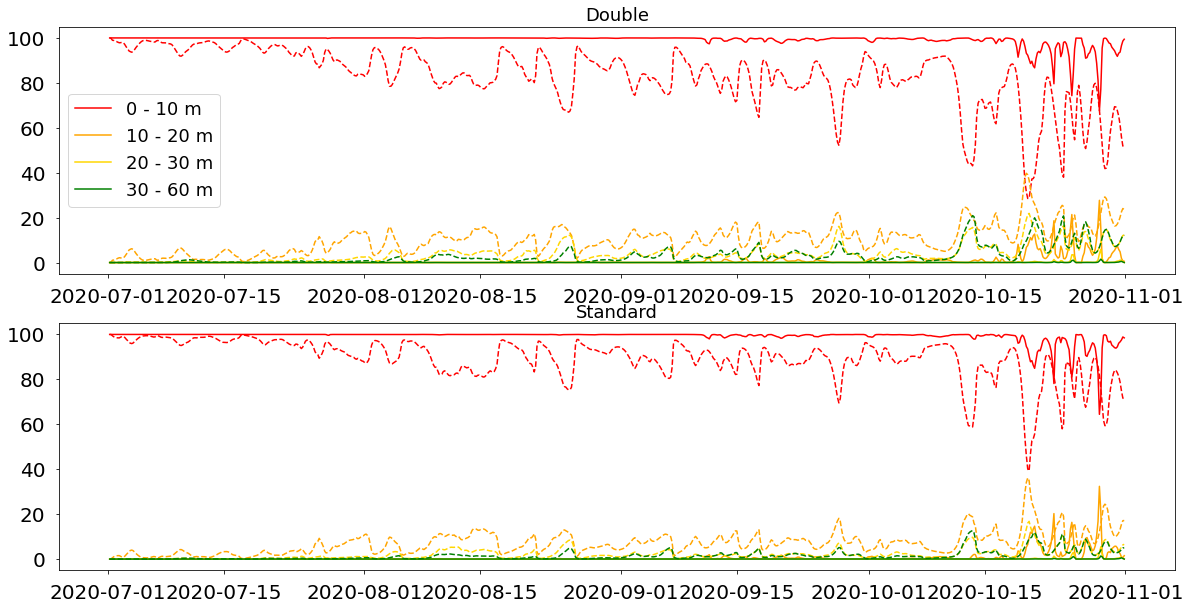

In [29]:
# Do line plots just to see how things look 
fig, ax = plt.subplots(2, figsize=(20,10))

# Sensitivity test
ax[0].plot(riv_sed_percent_double.ocean_time, riv_sed_percent_double.percent_0_10m_agg_double, color='red', label='0 - 10 m')
ax[0].plot(riv_sed_percent_double.ocean_time, riv_sed_percent_double.percent_0_10m_unag_double, color='red', linestyle='--')
ax[0].plot(riv_sed_percent_double.ocean_time, riv_sed_percent_double.percent_10_20m_agg_double, color='orange', label='10 - 20 m')
ax[0].plot(riv_sed_percent_double.ocean_time, riv_sed_percent_double.percent_10_20m_unag_double, color='orange', linestyle='--')
ax[0].plot(riv_sed_percent_double.ocean_time, riv_sed_percent_double.percent_20_30m_agg_double, color='gold', label='20 - 30 m')
ax[0].plot(riv_sed_percent_double.ocean_time, riv_sed_percent_double.percent_20_30m_unag_double, color='gold', linestyle='--')
ax[0].plot(riv_sed_percent_double.ocean_time, riv_sed_percent_double.percent_30_60m_agg_double, color='green', label='30 - 60 m')
ax[0].plot(riv_sed_percent_double.ocean_time, riv_sed_percent_double.percent_30_60m_unag_double, color='green', linestyle='--')
ax[0].set_title('Double', fontsize=fontsize-2)
ax[0].legend(fontsize=fontsize-2)

# Standard 
ax[1].sharex(ax[0])
ax[1].plot(riv_sed_percent_std.ocean_time, riv_sed_percent_std.percent_0_10m_agg_std, color='red', label='0 - 10 m')
ax[1].plot(riv_sed_percent_std.ocean_time, riv_sed_percent_std.percent_0_10m_unag_std, color='red', linestyle='--')
ax[1].plot(riv_sed_percent_std.ocean_time, riv_sed_percent_std.percent_10_20m_agg_std, color='orange', label='10 - 20 m')
ax[1].plot(riv_sed_percent_std.ocean_time, riv_sed_percent_std.percent_10_20m_unag_std, color='orange', linestyle='--')
ax[1].plot(riv_sed_percent_std.ocean_time, riv_sed_percent_std.percent_20_30m_agg_std, color='gold', label='20 - 30 m')
ax[1].plot(riv_sed_percent_std.ocean_time, riv_sed_percent_std.percent_20_30m_unag_std, color='gold', linestyle='--')
ax[1].plot(riv_sed_percent_std.ocean_time, riv_sed_percent_std.percent_30_60m_agg_std, color='green', label='30 - 60 m')
ax[1].plot(riv_sed_percent_std.ocean_time, riv_sed_percent_std.percent_30_60m_unag_std, color='green', linestyle='--')
ax[1].set_title('Standard', fontsize=fontsize-2)

In [30]:
# Chat GPT things

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Step 1: Function to flatten data
def flatten_for_boxplot(data_list, labels, depth_label):
    flat_data = []
    flat_labels = []
    depth_labels = []
    for i, series in enumerate(data_list):
        flat_data.extend(series.values.tolist())  # <-- fix is here
        flat_labels.extend([labels[i]] * len(series))
        depth_labels.extend([depth_label] * len(series))
    return pd.DataFrame({'value': flat_data, 'label': flat_labels, 'depth': depth_labels})

# Step 2: Your data and labels
depth_bins = [
    ("0 - 10 m", river_sed_percent_0_10m),
    ("10 - 20 m", river_sed_percent_10_20m),
    ("20 - 30 m", river_sed_percent_20_30m),
    ("30 - 60 m", river_sed_percent_30_60m)
]

# Assuming you have 10 sites and each has Agg + Unag
num_sites = len(river_sed_percent_0_10m) // 2
labels = [f"Agg.{i+1}" if j % 2 == 0 else f"Unag.{i+1}" for i in range(num_sites) for j in range(2)]

# Step 3: Combine all data
all_df = pd.concat(
    [flatten_for_boxplot(data_list, labels, depth) for depth, data_list in depth_bins],
    ignore_index=True
)

/projects/brun1463/software/anaconda/envs/xesmf_env/lib/python3.7/site-packages/ipykernel_launcher.py:83: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.


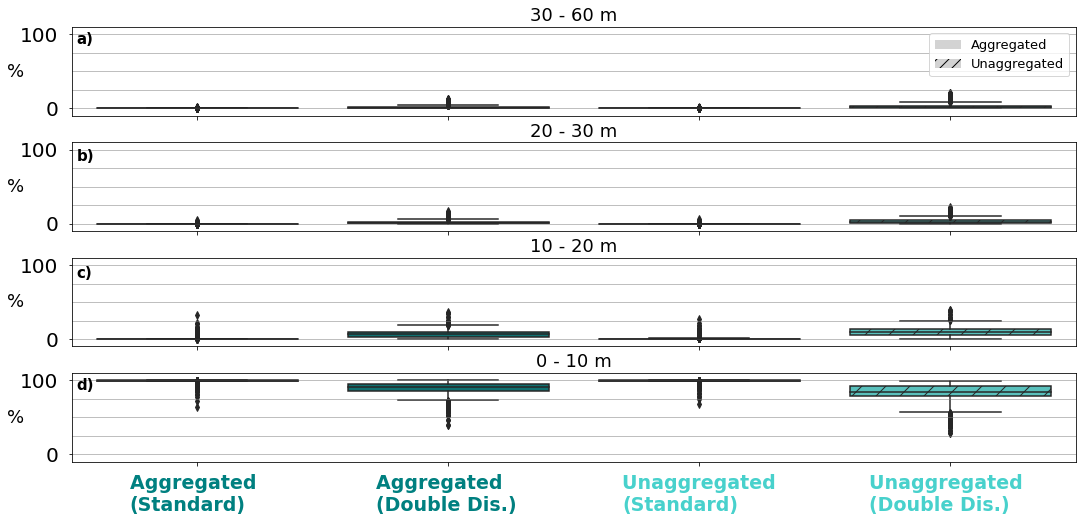

In [31]:
# Set subplot labels 
subplot_titles = ['30 - 60 m', '20 - 30 m', '10 - 20 m', '0 - 10 m']

# Make a palette
river_palette_std_double = ['teal', 'teal', 'mediumturquoise', 'mediumturquoise']

# Make the figure 
fig2, ax2 = plt.subplots(4, figsize=(18,8)) # 18, 8

# Plot the data as a boxplot
s8 = sns.boxplot(data=river_sed_percent_0_10m, ax=ax2[3], palette=river_palette_std_double)
s9 = sns.boxplot(data=river_sed_percent_10_20m, ax=ax2[2], palette=river_palette_std_double)
s10 = sns.boxplot(data=river_sed_percent_20_30m, ax=ax2[1], palette=river_palette_std_double)
s11 = sns.boxplot(data=river_sed_percent_30_60m, ax=ax2[0], palette=river_palette_std_double)

# Loop through axes to plot things
for r in range(4):
    # Add hashes
    # Set the hatch
    hatches = ["/"]
    for i, patch in enumerate(ax2[r].patches):
    # Apply to every other box
    #if i % 2 == 1: 
        if (i == 2) or (i == 3): 
            patch.set_hatch(hatches[i // 2 % len(hatches)]) 

    # Label the subplot
    ax2[r].set_title(subplot_titles[r], fontsize=fontsize-2)
    
    # Hide x-axis labels
    plt.setp(ax2[r].get_xticklabels(), visible=False)

    # Set y-axis label
    ax2[r].set_ylabel('%', fontsize=fontsize-2, rotation=0, va='center')
    
    # Set the y-limit
    ax2[r].set_ylim(-10,110) # (-10,110)

    # Add bars for 25, 50, 75 percent
    ax2[r].axhline(y=0, linestyle='-', color='gray', linewidth=0.5)
    ax2[r].axhline(y=25, linestyle='-', color='gray', linewidth=0.5)
    ax2[r].axhline(y=50, linestyle='-', color='gray', linewidth=0.5)
    ax2[r].axhline(y=75, linestyle='-', color='gray', linewidth=0.5)
    ax2[r].axhline(y=100, linestyle='-', color='gray', linewidth=0.5)

# Set different y-limits for each axis
# ax2[0].set_ylim(-10,30)
# ax2[1].set_ylim(-10,30)
# ax2[2].set_ylim(-10,50)
# ax2[3].set_ylim(20,110)

# Title the plot
#fig2.suptitle('Percent River Suspended Sediment in Different Depth Regions', x=0.5, y=0.97, fontsize=fontsize-1)
#ax2[0].set_title('Aggregated', fontsize=fontsize-2)
#ax2[1].set_title('Unaggregated', fontsize=fontsize-2)

# Adjust the spacing 
fig2.subplots_adjust(hspace=0.30)

# Add subplot labels 
# top left
fig2.text(0.129, 0.850, 'a)', color='black', fontsize=fontsize-5, weight='bold')
fig2.text(0.129, 0.648, 'b)', color='black', fontsize=fontsize-5, weight='bold')
fig2.text(0.129, 0.445, 'c)', color='black', fontsize=fontsize-5, weight='bold')
fig2.text(0.129, 0.250, 'd)', color='black', fontsize=fontsize-5, weight='bold')
# top right
# fig2.text(0.885, 0.850, 'a)', color='black', fontsize=fontsize-5, weight='bold')
# fig2.text(0.885, 0.648, 'b)', color='black', fontsize=fontsize-5, weight='bold')
# fig2.text(0.885, 0.445, 'c)', color='black', fontsize=fontsize-5, weight='bold')
# fig2.text(0.885, 0.250, 'd)', color='black', fontsize=fontsize-5, weight='bold')


# Manually place section labels 
fig2.text(0.17, 0.04, 'Aggregated \n(Standard)', color=river_palette_std_double[0], fontsize=fontsize-1, weight='bold')
fig2.text(0.36, 0.04, 'Aggregated \n(Double Dis.)', color=river_palette_std_double[1], fontsize=fontsize-1, weight='bold')
fig2.text(0.55, 0.04, 'Unaggregated \n(Standard)', color=river_palette_std_double[2], fontsize=fontsize-1, weight='bold')
fig2.text(0.74, 0.04, 'Unaggregated \n(Double Dis.)', color=river_palette_std_double[3], fontsize=fontsize-1, weight='bold')

# Make a legend
# Create the custom legend entries
solid_fill_patch = mpatches.Patch(facecolor='lightgray', label='Aggregated')
hatched_fill_patch = mpatches.Patch(facecolor='lightgray', hatch='//', label='Unaggregated')
ax2[0].legend(s11, handles=[solid_fill_patch, hatched_fill_patch], fontsize=fontsize-7, loc='upper right') # upper left, upper right

# # Add bars for 25, 50, 75 percent


In [39]:
# Repeat things from above to be able to pot this

# Step 1: Function to flatten data
def flatten_for_boxplot(data_list, labels, depth_label):
    flat_data = []
    flat_labels = []
    depth_labels = []
    for i, series in enumerate(data_list):
        flat_data.extend(series.values.tolist())  # <-- fix is here
        flat_labels.extend([labels[i]] * len(series))
        depth_labels.extend([depth_label] * len(series))
    return pd.DataFrame({'value': flat_data, 'label': flat_labels, 'depth': depth_labels})

# Step 2: Your data and labels
depth_bins = [
    ("0 - 10 m", river_allsed_percent_0_10m),
    ("10 - 20 m", river_allsed_percent_10_20m),
    ("20 - 30 m", river_allsed_percent_20_30m),
    ("30 - 60 m", river_allsed_percent_30_60m)
]

# Assuming you have 10 sites and each has Agg + Unag
num_sites = len(river_sed_percent_0_10m) // 2
labels = [f"Agg.{i+1}" if j % 2 == 0 else f"Unag.{i+1}" for i in range(num_sites) for j in range(2)]

# Step 3: Combine all data
all_df = pd.concat(
    [flatten_for_boxplot(data_list, labels, depth) for depth, data_list in depth_bins],
    ignore_index=True
)

Text(0.63, 0.04, 'Double Discharge')

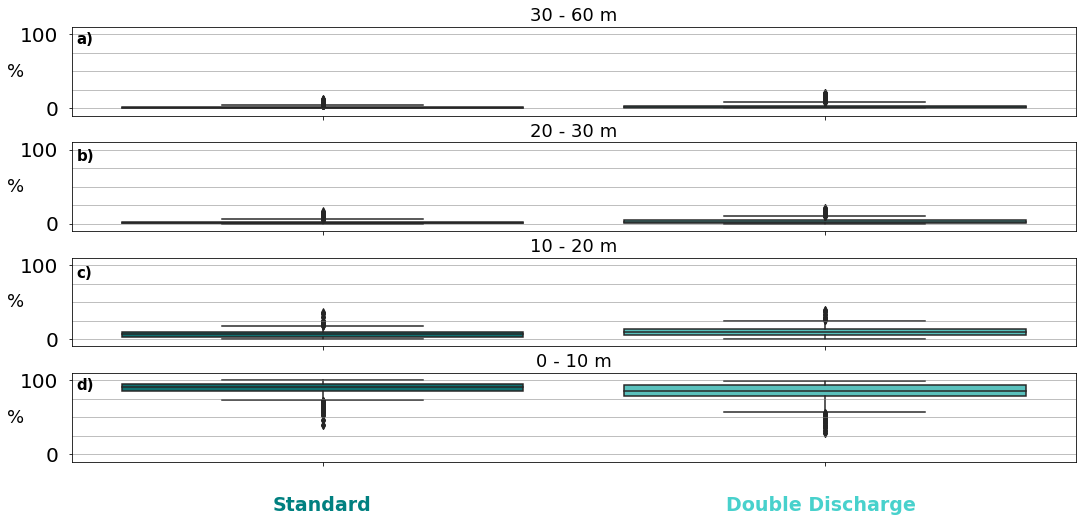

In [49]:
# Make a version that combines aggregated and unaggregated 
# mud for all rivers so it is just two box and whiskers per region

# Set subplot labels 
subplot_titles = ['30 - 60 m', '20 - 30 m', '10 - 20 m', '0 - 10 m']

# Make a palette
river_palette_std_double2 = ['teal', 'mediumturquoise']

# Make the figure 
fig2, ax2 = plt.subplots(4, figsize=(18,8)) # 18, 8

# Plot the data as a boxplot
s8 = sns.boxplot(data=river_allsed_percent_0_10m, ax=ax2[3], palette=river_palette_std_double2)
s9 = sns.boxplot(data=river_allsed_percent_10_20m, ax=ax2[2], palette=river_palette_std_double2)
s10 = sns.boxplot(data=river_allsed_percent_20_30m, ax=ax2[1], palette=river_palette_std_double2)
s11 = sns.boxplot(data=river_allsed_percent_30_60m, ax=ax2[0], palette=river_palette_std_double2)

# Loop through axes to plot things
for r in range(4):
    # Add hashes
    # Set the hatch
    hatches = ["/"]
    for i, patch in enumerate(ax2[r].patches):
    # Apply to every other box
    #if i % 2 == 1: 
        if (i == 2) or (i == 3): 
            patch.set_hatch(hatches[i // 2 % len(hatches)]) 

    # Label the subplot
    ax2[r].set_title(subplot_titles[r], fontsize=fontsize-2)
    
    # Hide x-axis labels
    plt.setp(ax2[r].get_xticklabels(), visible=False)

    # Set y-axis label
    ax2[r].set_ylabel('%', fontsize=fontsize-2, rotation=0, va='center')
    
    # Set the y-limit
    ax2[r].set_ylim(-10,110) # (-10,110)

    # Add bars for 25, 50, 75 percent
    ax2[r].axhline(y=0, linestyle='-', color='gray', linewidth=0.5)
    ax2[r].axhline(y=25, linestyle='-', color='gray', linewidth=0.5)
    ax2[r].axhline(y=50, linestyle='-', color='gray', linewidth=0.5)
    ax2[r].axhline(y=75, linestyle='-', color='gray', linewidth=0.5)
    ax2[r].axhline(y=100, linestyle='-', color='gray', linewidth=0.5)

# Set different y-limits for each axis
# ax2[0].set_ylim(-10,30)
# ax2[1].set_ylim(-10,30)
# ax2[2].set_ylim(-10,50)
# ax2[3].set_ylim(20,110)

# Title the plot
#fig2.suptitle('Percent River Suspended Sediment in Different Depth Regions', x=0.5, y=0.97, fontsize=fontsize-1)
#ax2[0].set_title('Aggregated', fontsize=fontsize-2)
#ax2[1].set_title('Unaggregated', fontsize=fontsize-2)

# Adjust the spacing 
fig2.subplots_adjust(hspace=0.30)

# Add subplot labels 
# top left
fig2.text(0.129, 0.850, 'a)', color='black', fontsize=fontsize-5, weight='bold')
fig2.text(0.129, 0.648, 'b)', color='black', fontsize=fontsize-5, weight='bold')
fig2.text(0.129, 0.445, 'c)', color='black', fontsize=fontsize-5, weight='bold')
fig2.text(0.129, 0.250, 'd)', color='black', fontsize=fontsize-5, weight='bold')
# top right
# fig2.text(0.885, 0.850, 'a)', color='black', fontsize=fontsize-5, weight='bold')
# fig2.text(0.885, 0.648, 'b)', color='black', fontsize=fontsize-5, weight='bold')
# fig2.text(0.885, 0.445, 'c)', color='black', fontsize=fontsize-5, weight='bold')
# fig2.text(0.885, 0.250, 'd)', color='black', fontsize=fontsize-5, weight='bold')


# Manually place section labels 
fig2.text(0.28, 0.04, 'Standard', color=river_palette_std_double2[0], fontsize=fontsize-1, weight='bold')
fig2.text(0.63, 0.04, 'Double Discharge', color=river_palette_std_double2[1], fontsize=fontsize-1, weight='bold')

# Make a legend
# Create the custom legend entries
# solid_fill_patch = mpatches.Patch(facecolor='lightgray', label='Aggregated')
# hatched_fill_patch = mpatches.Patch(facecolor='lightgray', hatch='//', label='Unaggregated')
# ax2[0].legend(s11, handles=[solid_fill_patch, hatched_fill_patch], fontsize=fontsize-7, loc='upper right') # upper left, upper right

# # Add bars for 25, 50, 75 percent

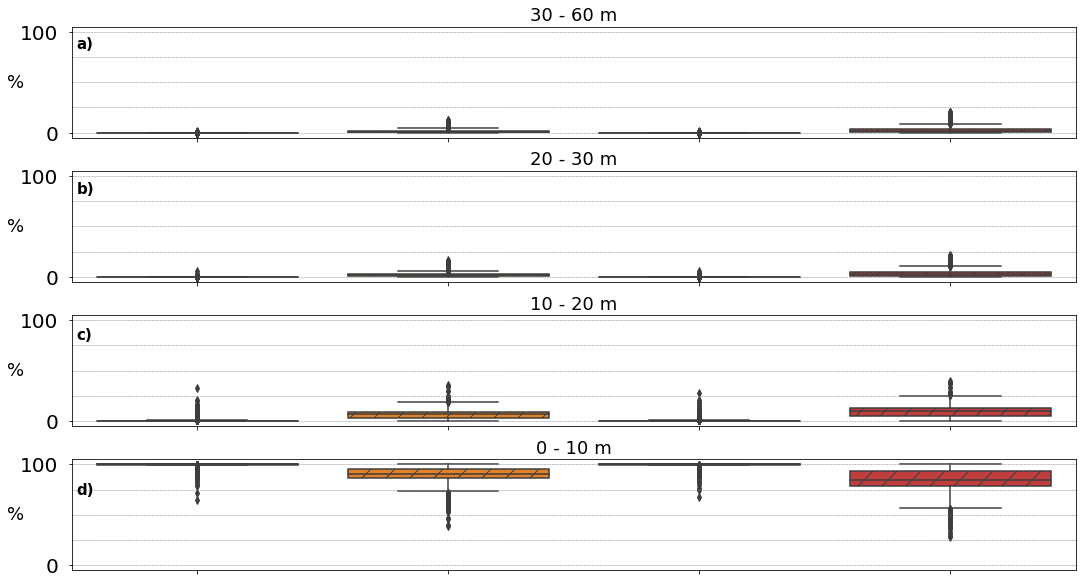

In [33]:
# Try makikng a plot
# CHat GPT things 
# Step 4: Create the figure and subplots
fig2, ax2 = plt.subplots(4, figsize=(18, 10), sharex=True)

# Plot each depth bin in the correct subplot
for i, (depth, _) in enumerate(depth_bins[::-1]):  # reverse so 0-10m is at bottom
    ax = ax2[i]
    df_depth = all_df[all_df['depth'] == depth]
    sns.boxplot(data=df_depth, x='label', y='value', ax=ax) #, palette=river_pallette_colors_doubles)

    # Optional: Add hatching to Unag entries
    for j, patch in enumerate(ax.patches):
        if 'Unag' in df_depth['label'].unique()[j]:
            patch.set_hatch('/')

    ax.set_ylabel('%', fontsize=fontsize-2, rotation=0, va='center')
    ax.set_ylim(-5, 105)
    ax.axhline(y=0, linestyle='--', color='gray', linewidth=0.5)
    ax.axhline(y=25, linestyle='--', color='gray', linewidth=0.5)
    ax.axhline(y=50, linestyle='--', color='gray', linewidth=0.5)
    ax.axhline(y=75, linestyle='--', color='gray', linewidth=0.5)
    ax.axhline(y=100, linestyle='--', color='gray', linewidth=0.5)
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_title(depth, fontsize=fontsize-2)

# Set hatches to the second/unaggregated data
#hatches = ["/", "o", "*", "\\", "/", "o", "*", "\\", "/", "o", "*", "\\", "/", "o", "*"]
# # Set the hatch
# hatches = ["/"]
# # Loop through patches for sections 1 - 7 
# for i, patch in enumerate(ax2[0].patches):
#     # Apply to every other box
#     if i % 2 == 1:  
#         patch.set_hatch(hatches[i // 2 % len(hatches)])  
# # Loop through patches for sections 8 - 13 
# for i, patch in enumerate(ax2[1].patches):
#     # Apply to every other box
#     if i % 2 == 1:  
#         patch.set_hatch(hatches[i // 2 % len(hatches)])  
# for i, patch in enumerate(ax2[2].patches):
#     # Apply to every other box
#     if i % 2 == 1:  
#         patch.set_hatch(hatches[i // 2 % len(hatches)]) 
# for i, patch in enumerate(ax2[3].patches):
#     # Apply to every other box
#     if i % 2 == 1:  
#         patch.set_hatch(hatches[i // 2 % len(hatches)]) 

#ig2.suptitle('Percent River Suspended Sediment in Different Depth Regions', x=0.5, y=0.93, fontsize=fontsize-1)
#ax2[0].set_title('Aggregated', fontsize=fontsize-2)
#ax2[1].set_title('Unaggregated', fontsize=fontsize-2)

# Adjust the spacing 
fig2.subplots_adjust(hspace=0.30)


# Manually place river labels 
# fig2.text(0.135, 0.08, 'Kalikpik', color=river_pallette_colors_doubles[0], fontsize=fontsize-5, weight='bold')
# fig2.text(0.205, 0.08, 'Fish Creek', color=river_pallette_colors_doubles[2], fontsize=fontsize-5, weight='bold')
# fig2.text(0.295, 0.08, 'Colville', color=river_pallette_colors_doubles[4], fontsize=fontsize-5, weight='bold')
# fig2.text(0.370, 0.08, 'Kuparik', color=river_pallette_colors_doubles[6], fontsize=fontsize-5, weight='bold')
# fig2.text(0.428, 0.08, 'Sagavanirktok', color=river_pallette_colors_doubles[8], fontsize=fontsize-5, weight='bold')
# fig2.text(0.530, 0.08, 'Staines', color=river_pallette_colors_doubles[10], fontsize=fontsize-5, weight='bold')
# fig2.text(0.605, 0.08, 'Canning', color=river_pallette_colors_doubles[12], fontsize=fontsize-5, weight='bold')
# fig2.text(0.670, 0.08, 'Katakturuk', color=river_pallette_colors_doubles[14], fontsize=fontsize-5, weight='bold')
# fig2.text(0.755, 0.08, 'Hulahula', color=river_pallette_colors_doubles[16], fontsize=fontsize-5, weight='bold')
# fig2.text(0.845, 0.08, 'Jago', color=river_pallette_colors_doubles[18], fontsize=fontsize-5, weight='bold')

# Add subplot labels 
fig2.text(0.129, 0.850, 'a)', color='black', fontsize=fontsize-5, weight='bold')
fig2.text(0.129, 0.648, 'b)', color='black', fontsize=fontsize-5, weight='bold')
fig2.text(0.129, 0.445, 'c)', color='black', fontsize=fontsize-5, weight='bold')
fig2.text(0.129, 0.230, 'd)', color='black', fontsize=fontsize-5, weight='bold')


# Make a legend
# Create the custom legend entries
solid_fill_patch = mpatches.Patch(facecolor='lightgray', label='Aggregated')
hatched_fill_patch = mpatches.Patch(facecolor='lightgray', hatch='//', label='Unaggregated')
#plt.legend(s4, handles=[solid_fill_patch, hatched_fill_patch], fontsize=fontsize-7, loc='lower left')


plt.show()

#### Statistics!


In [35]:
# Print a bunch of stats!
#river_sed_percent_0_10m = (riv_sed_percent_std.percent_0_10m_agg_std[:716], riv_sed_percent_std.percent_0_10m_unag_std[:716], riv_sed_percent_double.percent_0_10m_agg_double, riv_sed_percent_double.percent_0_10m_unag_double)
# Means 
# 0 - 10
print('0 - 10 m')
print('mean percent_0_10m_agg_std: ', np.nanmean(riv_sed_percent_std.percent_0_10m_agg_std[:716]))
print('mean percent_0_10m_unag_std: ', np.nanmean(riv_sed_percent_std.percent_0_10m_unag_std[:716]))
print('mean percent_0_10m_agg_double: ', np.nanmean(riv_sed_percent_double.percent_0_10m_agg_double[:716]))
print('mean percent_0_10m_unag_double: ', np.nanmean(riv_sed_percent_double.percent_0_10m_unag_double[:716]))
# 10 - 20 
print('10 - 20 m')
print('mean percent_10_20m_agg_std: ', np.nanmean(riv_sed_percent_std.percent_10_20m_agg_std[:716]))
print('mean percent_10_20m_unag_std: ', np.nanmean(riv_sed_percent_std.percent_10_20m_unag_std[:716]))
print('mean percent_10_20m_agg_double: ', np.nanmean(riv_sed_percent_double.percent_10_20m_agg_double[:716]))
print('mean percent_10_20m_unag_double: ', np.nanmean(riv_sed_percent_double.percent_10_20m_unag_double[:716]))
# 20 - 30 
print('20 - 30 m')
print('mean percent_20_30m_agg_std: ', np.nanmean(riv_sed_percent_std.percent_20_30m_agg_std[:716]))
print('mean percent_20_30m_unag_std: ', np.nanmean(riv_sed_percent_std.percent_20_30m_unag_std[:716]))
print('mean percent_20_30m_agg_double: ', np.nanmean(riv_sed_percent_double.percent_20_30m_agg_double[:716]))
print('mean percent_20_30m_unag_double: ', np.nanmean(riv_sed_percent_double.percent_20_30m_unag_double[:716]))
# 30 - 60 
print('30 - 60 m')
print('mean percent_30_60m_agg_std: ', np.nanmean(riv_sed_percent_std.percent_30_60m_agg_std[:716]))
print('mean percent_30_60m_unag_std: ', np.nanmean(riv_sed_percent_std.percent_30_60m_unag_std[:716]))
print('mean percent_30_60m_agg_double: ', np.nanmean(riv_sed_percent_double.percent_30_60m_agg_double[:716]))
print('mean percent_30_60m_unag_double: ', np.nanmean(riv_sed_percent_double.percent_30_60m_unag_double[:716]))


0 - 10 m
mean percent_0_10m_agg_std:  99.40115105634119
mean percent_0_10m_unag_std:  89.70004792511203
mean percent_0_10m_agg_double:  99.295337838906
mean percent_0_10m_unag_double:  83.90338003523192
10 - 20 m
mean percent_10_20m_agg_std:  0.5694589020388177
mean percent_10_20m_unag_std:  6.837332600289392
mean percent_10_20m_agg_double:  0.6638857104748233
mean percent_10_20m_unag_double:  9.807103129254779
20 - 30 m
mean percent_20_30m_agg_std:  0.023386004762971795
mean percent_20_30m_unag_std:  2.0137640098547793
mean percent_20_30m_agg_double:  0.03363876850935285
mean percent_20_30m_unag_double:  3.514924981747913
30 - 60 m
mean percent_30_60m_agg_std:  0.0060040368570158315
mean percent_30_60m_unag_std:  1.4488554647437935
mean percent_30_60m_agg_double:  0.007137682109825766
mean percent_30_60m_unag_double:  2.774591853765399


In [36]:
# Standard deviation 
# 0 - 10
print('0 - 10 m')
print('stddev percent_0_10m_agg_std: ', np.nanstd(riv_sed_percent_std.percent_0_10m_agg_std[:716]))
print('stddev percent_0_10m_unag_std: ', np.nanstd(riv_sed_percent_std.percent_0_10m_unag_std[:716]))
print('stddev percent_0_10m_agg_double: ', np.nanstd(riv_sed_percent_double.percent_0_10m_agg_double[:716]))
print('stddev percent_0_10m_unag_double: ', np.nanstd(riv_sed_percent_double.percent_0_10m_unag_double[:716]))
# 10 - 20 
print('10 - 20 m')
print('stddev percent_10_20m_agg_std: ', np.nanstd(riv_sed_percent_std.percent_10_20m_agg_std[:716]))
print('stddev percent_10_20m_unag_std: ', np.nanstd(riv_sed_percent_std.percent_10_20m_unag_std[:716]))
print('stddev percent_10_20m_agg_double: ', np.nanstd(riv_sed_percent_double.percent_10_20m_agg_double[:716]))
print('stddev percent_10_20m_unag_double: ', np.nanstd(riv_sed_percent_double.percent_10_20m_unag_double[:716]))
# 20 - 30 
print('20 - 30 m')
print('stddev percent_20_30m_agg_std: ', np.nanstd(riv_sed_percent_std.percent_20_30m_agg_std[:716]))
print('stddev percent_20_30m_unag_std: ', np.nanstd(riv_sed_percent_std.percent_20_30m_unag_std[:716]))
print('stddev percent_20_30m_agg_double: ', np.nanstd(riv_sed_percent_double.percent_20_30m_agg_double[:716]))
print('stddev percent_20_30m_unag_double: ', np.nanstd(riv_sed_percent_double.percent_20_30m_unag_double[:716]))
# 30 - 60 
print('30 - 60 m')
print('stddev percent_30_60m_agg_std: ', np.nanstd(riv_sed_percent_std.percent_30_60m_agg_std[:716]))
print('stddev percent_30_60m_unag_std: ', np.nanstd(riv_sed_percent_std.percent_30_60m_unag_std[:716]))
print('stddev percent_30_60m_agg_double: ', np.nanstd(riv_sed_percent_double.percent_30_60m_agg_double[:716]))
print('stddev percent_30_60m_unag_double: ', np.nanstd(riv_sed_percent_double.percent_30_60m_unag_double[:716]))


0 - 10 m
stddev percent_0_10m_agg_std:  2.0784785601690103
stddev percent_0_10m_unag_std:  8.692272625476418
stddev percent_0_10m_agg_double:  2.200454295694217
stddev percent_0_10m_unag_double:  12.510244716669868
10 - 20 m
stddev percent_10_20m_agg_std:  1.9451851063528083
stddev percent_10_20m_unag_std:  4.737193424383121
stddev percent_10_20m_agg_double:  2.00497748715906
stddev percent_10_20m_unag_double:  5.907043231684032
20 - 30 m
stddev percent_20_30m_agg_std:  0.16178558077448144
stddev percent_20_30m_unag_std:  2.2653373193408273
stddev percent_20_30m_agg_double:  0.21178651332093396
stddev percent_20_30m_unag_double:  3.5677900620235823
30 - 60 m
stddev percent_30_60m_agg_std:  0.05530886944821486
stddev percent_30_60m_unag_std:  2.0661862698492057
stddev percent_30_60m_agg_double:  0.05659311910893149
stddev percent_30_60m_unag_double:  3.7734384303257555


In [37]:
# Min 
# 0 - 10
print('0 - 10 m')
print('min percent_0_10m_agg_std: ', np.nanmin(riv_sed_percent_std.percent_0_10m_agg_std[:716]))
print('min percent_0_10m_unag_std: ', np.nanmin(riv_sed_percent_std.percent_0_10m_unag_std[:716]))
print('min percent_0_10m_agg_double: ', np.nanmin(riv_sed_percent_double.percent_0_10m_agg_double[:716]))
print('min percent_0_10m_unag_double: ', np.nanmin(riv_sed_percent_double.percent_0_10m_unag_double[:716]))
# 10 - 20 
print('10 - 20 m')
print('min percent_10_20m_agg_std: ', np.nanmin(riv_sed_percent_std.percent_10_20m_agg_std[:716]))
print('min percent_10_20m_unag_std: ', np.nanmin(riv_sed_percent_std.percent_10_20m_unag_std[:716]))
print('min percent_10_20m_agg_double: ', np.nanmin(riv_sed_percent_double.percent_10_20m_agg_double[:716]))
print('min percent_10_20m_unag_double: ', np.nanmin(riv_sed_percent_double.percent_10_20m_unag_double[:716]))
# 20 - 30 
print('20 - 30 m')
print('min percent_20_30m_agg_std: ', np.nanmin(riv_sed_percent_std.percent_20_30m_agg_std[:716]))
print('min percent_20_30m_unag_std: ', np.nanmin(riv_sed_percent_std.percent_20_30m_unag_std[:716]))
print('min percent_20_30m_agg_double: ', np.nanmin(riv_sed_percent_double.percent_20_30m_agg_double[:716]))
print('min percent_20_30m_unag_double: ', np.nanmin(riv_sed_percent_double.percent_20_30m_unag_double[:716]))
# 30 - 60 
print('30 - 60 m')
print('min percent_30_60m_agg_std: ', np.nanmin(riv_sed_percent_std.percent_30_60m_agg_std[:716]))
print('min percent_30_60m_unag_std: ', np.nanmin(riv_sed_percent_std.percent_30_60m_unag_std[:716]))
print('min percent_30_60m_agg_double: ', np.nanmin(riv_sed_percent_double.percent_30_60m_agg_double[:716]))
print('min percent_30_60m_unag_double: ', np.nanmin(riv_sed_percent_double.percent_30_60m_unag_double[:716]))

0 - 10 m
min percent_0_10m_agg_std:  78.144816450479
min percent_0_10m_unag_std:  39.234454109194125
min percent_0_10m_agg_double:  74.31529716620409
min percent_0_10m_unag_double:  28.53544593845664
10 - 20 m
min percent_10_20m_agg_std:  4.368536694072548e-09
min percent_10_20m_unag_std:  0.0018641941568870106
min percent_10_20m_agg_double:  1.259395618219443e-08
min percent_10_20m_unag_double:  0.04906909660503009
20 - 30 m
min percent_20_30m_agg_std:  1.1615699056559845e-16
min percent_20_30m_unag_std:  1.2121936993596228e-13
min percent_20_30m_agg_double:  4.499919653080013e-16
min percent_20_30m_unag_double:  6.762747139537354e-13
30 - 60 m
min percent_30_60m_agg_std:  2.3778007102669454e-22
min percent_30_60m_unag_std:  2.0976045718883217e-20
min percent_30_60m_agg_double:  1.0652110815315215e-21
min percent_30_60m_unag_double:  3.846578519573008e-20


In [38]:
# Max
# 0 - 10
print('0 - 10 m')
print('max percent_0_10m_agg_std: ', np.nanmax(riv_sed_percent_std.percent_0_10m_agg_std[:716]))
print('max percent_0_10m_unag_std: ', np.nanmax(riv_sed_percent_std.percent_0_10m_unag_std[:716]))
print('max percent_0_10m_agg_double: ', np.nanmax(riv_sed_percent_double.percent_0_10m_agg_double[:716]))
print('max percent_0_10m_unag_double: ', np.nanmax(riv_sed_percent_double.percent_0_10m_unag_double[:716]))
# 10 - 20 
print('10 - 20 m')
print('max percent_10_20m_agg_std: ', np.nanmax(riv_sed_percent_std.percent_10_20m_agg_std[:716]))
print('max percent_10_20m_unag_std: ', np.nanmax(riv_sed_percent_std.percent_10_20m_unag_std[:716]))
print('max percent_10_20m_agg_double: ', np.nanmax(riv_sed_percent_double.percent_10_20m_agg_double[:716]))
print('max percent_10_20m_unag_double: ', np.nanmax(riv_sed_percent_double.percent_10_20m_unag_double[:716]))
# 20 - 30 
print('20 - 30 m')
print('max percent_20_30m_agg_std: ', np.nanmax(riv_sed_percent_std.percent_20_30m_agg_std[:716]))
print('max percent_20_30m_unag_std: ', np.nanmax(riv_sed_percent_std.percent_20_30m_unag_std[:716]))
print('max percent_20_30m_agg_double: ', np.nanmax(riv_sed_percent_double.percent_20_30m_agg_double[:716]))
print('max percent_20_30m_unag_double: ', np.nanmax(riv_sed_percent_double.percent_20_30m_unag_double[:716]))
# 30 - 60 
print('30 - 60 m')
print('max percent_30_60m_agg_std: ', np.nanmax(riv_sed_percent_std.percent_30_60m_agg_std[:716]))
print('max percent_30_60m_unag_std: ', np.nanmax(riv_sed_percent_std.percent_30_60m_unag_std[:716]))
print('max percent_30_60m_agg_double: ', np.nanmax(riv_sed_percent_double.percent_30_60m_agg_double[:716]))
print('max percent_30_60m_unag_double: ', np.nanmax(riv_sed_percent_double.percent_30_60m_unag_double[:716]))

0 - 10 m
max percent_0_10m_agg_std:  99.9999999952906
max percent_0_10m_unag_std:  99.99813580584299
max percent_0_10m_agg_double:  99.9999999842544
max percent_0_10m_unag_double:  99.9509309033943
10 - 20 m
max percent_10_20m_agg_std:  20.241593090052852
max percent_10_20m_unag_std:  36.163995175708585
max percent_10_20m_agg_double:  21.37810181106541
max percent_10_20m_unag_double:  39.738549977048585
20 - 30 m
max percent_20_30m_agg_std:  2.9747262264437415
max percent_20_30m_unag_std:  16.79094645077822
max percent_20_30m_agg_double:  3.484481231539243
max percent_20_30m_unag_double:  21.901027805555238
30 - 60 m
max percent_30_60m_agg_std:  1.1266532510243197
max percent_30_60m_unag_std:  12.701330671122
max percent_30_60m_agg_double:  1.0521304829343487
max percent_30_60m_unag_double:  20.900233534012564
